In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cupy

class genData:
    '''
    Inputs
    ------------------------
    sigFreqs: array-like
        Frequencies to generate signals. 
        [MHz] 
    sigAmps: array-like
        Amplitudes for signals. 
        Units linear and proportional to voltage, but arbitrary
        Must be same length as sigFreqs 
    mean: float
        mean value for noise
    std: float
        standard deviation of noise
    numSamples: float
        numbers of samples to capture. Twice as long as the fft
    sampleRate: float
        rate samples are captured 
        [MHz]
    numAvg: int
        number of averages to be computed using averaging methods
    
    
    Attributes
    ------------------------
    timeArr: np array
        array of times which signal is sampled by ADC
        [us]
    freqs: np array
        frequencies corosponding to bins of fft
        [MHz]
    
    '''
    def __init__(self,
            sigFreqs, 
            sigAmps,
            mean,
            std, 
            numSamples,
            sampleRate,
            numAvg):
        
        #check for valid args
        if len(sigFreqs) != len(sigAmps):
            raise ValueError('sigFreqs and sigAmps must be same length')
        
        #assign attributes to args
        self.sigFreqs = sigFreqs
        self.sigAmps = sigAmps
        self.mean = mean
        self.std = std
        self.numSamples = numSamples
        self.numAvg = numAvg
        
        #compute additional attributes
        self._halfNumSamples = self.numSamples//2
        self.sampleRate = sampleRate
        self.timeArr = cupy.asarray([i for i in range(0, self.numSamples)])/self.sampleRate
        self._signals = cupy.zeros(len(self.timeArr))
        for i in range(len(self.sigFreqs)):
            self._signals += self.sigAmps[i] * cupy.sin(2*cupy.pi * self.sigFreqs[i] * self.timeArr)
        self.freqs = np.linspace(0, self.sampleRate//2, self.numSamples//2)[1:]
        self.genTimeDataGpu()
        
        '''
        ###Testing 8bit###
        self._signals = np.zeros(len(self.timeArr), dtype = np. int8)
        for i in range(len(self.sigFreqs)):
            self._signals += np.rint(self.sigAmps[i] * np.sin(2*np.pi * self.sigFreqs[i] * self.timeArr))
        '''
        
    def genTimeData(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = np.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*(self.fft**2)/(self.numSamples**2 * 50)
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeDataGpu(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = cupy.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = (noiseData + self._signals)
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = cupy.abs(cupy.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = cupy.asarray(2*self.fft**2/(self.numSamples**2 * 50))
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeData8Bit(self):
        noiseData = np.asarray(
            np.rint(np.random.normal(mean, std, 2**24)), dtype = np. int8)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)

        
    def computePowAvg(self):
        self.powAvg = cupy.asarray(self.powSpec)
        for i in range(1, self.numAvg):
            #print(i)
            self.genTimeDataGpu()
            self.powAvg = self.powAvg * (i-1)/i + self.powSpec/i

    def setNumAvg(self, numAvg):
        self.numAvg = numAvg


In [4]:
roomTemp = 300

NF = 1
ampTemp = 290  * (10**(NF/10) - 1)
sysTemp = ampTemp + roomTemp
print('System temp = ', round(sysTemp, 2), 'K')

kb = 1.380649e-23 #J/K
deltaNu = 35 #Hz

thermalNoiseDens = kb * sysTemp 

thermalNoiseDens_dBm = 10*np.log10(thermalNoiseDens * 1000)
thermalBg_dBm = 10*np.log10(thermalNoiseDens * deltaNu * 1000)

print('total thermal background = ', round(thermalNoiseDens_dBm, 2), 'dBm per Hz')
print('total thermal background = ', round(thermalBg_dBm, 2), 'dBm per bin')

def dBm2linPow(dBm):
    return(10**((dBm - 30) /10))

print('thermal background = ', dBm2linPow(thermalBg_dBm), 'W per bin')

numAvg = 1*np.sqrt(2)

System temp =  375.09 K
total thermal background =  -172.86 dBm per Hz
total thermal background =  -157.42 dBm per bin
thermal background =  1.8125288375312317e-19 W per bin


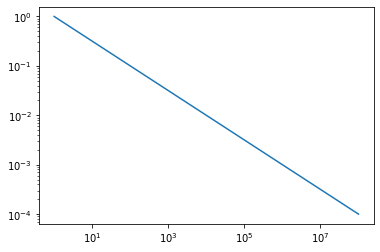

In [5]:
#plot averaging gain

logNumAvg = 8
numSteps = 10
avgGain = np.zeros(numSteps)
numAvgArr = np.zeros(numSteps)

for i, numAvg in enumerate(np.logspace(0, logNumAvg, numSteps)):
    avgGain[i] = 1/np.sqrt(numAvg)
    numAvgArr[i] = numAvg

plt.figure()
plt.loglog(numAvgArr, (avgGain))

In [12]:
sigFreqs = [.6790379]
mean = 0
numSamples = 2**14
sampleRate = 2 #MHz
numAvg = 1000000


roomTemp = 300
NF = .1
ampTemp = 290  * (10**(NF/10) - 1)
sysTemp = ampTemp + roomTemp
print('System temp = ', round(sysTemp, 2), 'K')

kb = 1.380649e-23 #J/K
deltaNu = sampleRate * 1e6 / numSamples

thermalNoiseDens = kb * sysTemp 

thermalNoiseDens_dBm = 10*np.log10(thermalNoiseDens * 1000)
thermalBg_dBm = 10*np.log10(thermalNoiseDens * deltaNu * 1000)

print('total thermal background = ', round(thermalNoiseDens_dBm, 2), 'dBm per Hz')
print('total thermal background = ', round(thermalBg_dBm, 2), 'dBm per bin')
print('bin width = ', deltaNu, 'Hz')

def dBm2linPow(dBm):
    return(10**((dBm - 30) /10))

print('thermal background = ', dBm2linPow(thermalBg_dBm), 'W per bin')

std = np.sqrt(thermalNoiseDens * (sampleRate * 1e6 / 2) * 50)
#std = 0
print('noise voltage = ', std, 'V')
stdTherm = 4.46e-10* 1.73e4 


powerMultplier = .08481 #linear multplier of sig power above noise

voltageMultplier = (2*powerMultplier)**0.5 #2 is for p2p
sigAmps = [np.sqrt(thermalNoiseDens * deltaNu * 50) * (voltageMultplier)]
#sigAmps = [5 * 0.707 * 2]
#sigAmps = [1**2 / 2]

if sigAmps[0]:
    print('\n##################Injected signal stuff###################')
    print('injected signal = ', sigAmps[0] * 2, 'Volts p2p')
    print('injected signal = ', 10* np.log10((sigAmps[0]*0.707)**2/50 * 1000), 'dBm')
    print('injected signal = ', (sigAmps[0]*0.707)**2/50, 'Watts')
    measMaxPow = genData(sigFreqs,sigAmps,mean,0,numSamples,sampleRate,numAvg).powSpec.get().max()
    print('Measured injected signal =', measMaxPow, 'Watts')
    print('Measured injected signal =', 10*np.log10(measMaxPow*1000), 'dBm')

myData = genData(sigFreqs,sigAmps,mean,std,numSamples,sampleRate,numAvg)

myData.computePowAvg();

System temp =  306.75 K
total thermal background =  -173.73 dBm per Hz
total thermal background =  -152.87 dBm per bin
bin width =  122.0703125 Hz
thermal background =  5.169933343320756e-19 W per bin
noise voltage =  4.6017439057646126e-07 V

##################Injected signal stuff###################
injected signal =  4.187897070592982e-09 Volts p2p
injected signal =  -163.58199169822964 dBm
injected signal =  4.383296313088841e-20 Watts
Measured injected signal = 3.081911775420982e-20 Watts
Measured injected signal = -165.11179797803277 dBm


limit =  2.6142389794623193e-21 W
limit (square) =  -1.0462243612950703e-21 W
Number of candidates =  3
computed mean power =  -152.86513 dBm
expected mean power =  -152.86515 dBm
-182.81624718445056


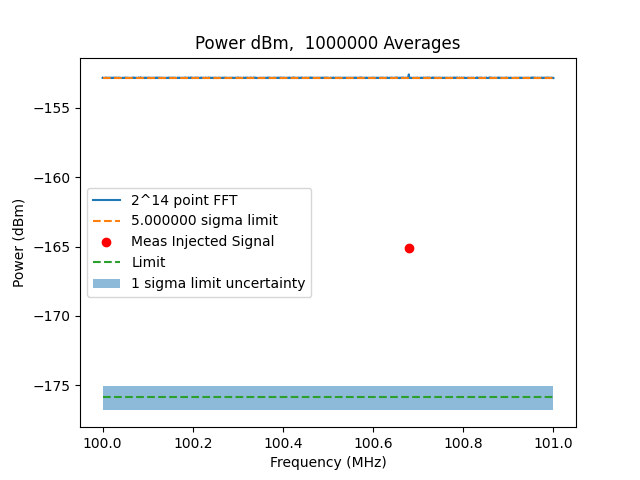

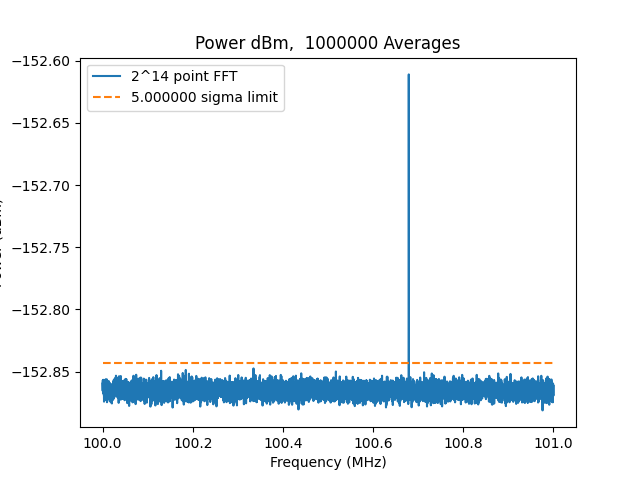

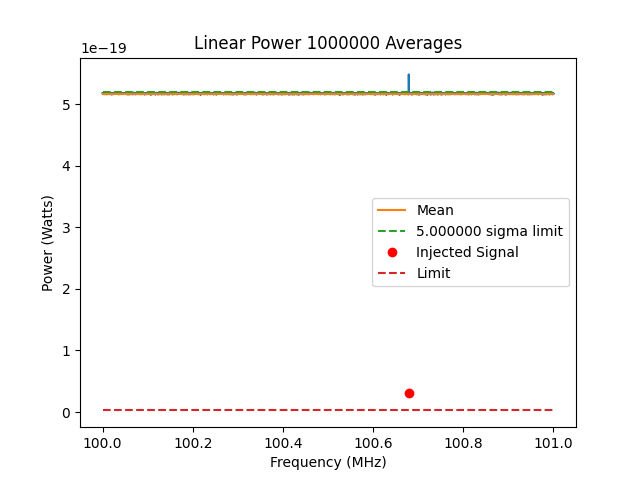

In [13]:

%matplotlib widget 

powAvg = myData.powAvg.get()
powAvgMean = np.median(powAvg) #median to not bias for large signal
powAvgStd = powAvg[0:numSamples//4].std() #only take first half to avoid .678MHz signal
numSigma = 5
powAvgLim = powAvgMean + (numSigma * powAvgStd)

#limit = (powAvgMean - numSigma * powAvgStd)
# limit = powAvgMean - (powAvgLim/powAvgMean) * powAvgMean 
limit =  numSigma * powAvgStd
print('limit = ', limit, 'W')

#limitSquare = powAvgMean - (powAvgLim/powAvgMean)**2 * powAvgMean 
limitSquare = powAvgMean - ((powAvgMean + powAvgStd)/powAvgMean)**2 * powAvgMean 


print('limit (square) = ', limitSquare, 'W')

numCandidates = (powAvg > powAvgLim).sum()
print('Number of candidates = ',numCandidates)


dBmPowAvgMean = 10 * np.log10(powAvgMean * 1000)
dBmPowAvgLim = 10 * np.log10(powAvgLim * 1000)

print('computed mean power = ', round(10*np.log10(powAvg.mean()*1000), 5), 'dBm')
print('expected mean power = ', round(thermalBg_dBm,5), 'dBm')

freqShift = 100 #MHz

plt.figure()
plt.title('Power dBm,  %i Averages' % numAvg )
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg*1000), 
        label = '2^%i point FFT ' % int(np.log2(numSamples)))
#plt.plot((freqShift,sampleRate/2 + freqShift),
#    (dBmPowAvgMean, dBmPowAvgMean), label= 'Mean')
plt.plot((freqShift,sampleRate/2 + freqShift),(dBmPowAvgLim, dBmPowAvgLim), 
        '--', label = '%f sigma limit' % numSigma)
plt.plot(sigFreqs[0] + freqShift, 10* np.log10(measMaxPow * 1000),
     'ro', label = 'Meas Injected Signal')
plt.plot((freqShift, sampleRate/2 + freqShift),
        (10*np.log10(limit*1000), 10*np.log10(limit*1000)), 
        '--', label= 'Limit')
plt.fill_between((freqShift, sampleRate/2 + freqShift),
        (10*np.log10((limit + powAvgStd)*1000) , 
        10*np.log10((limit + powAvgStd)*1000)),
        (10*np.log10((limit-powAvgStd)*1000),
         10*np.log10((limit-powAvgStd)*1000)),
         alpha = .5,
         label = '1 sigma limit uncertainty')
#plt.plot((freqShift, sampleRate/2 + freqShift),
        #(10*np.log10(limitSquare*1000), 10*np.log10(limitSquare*1000)), 
        #'--', label= 'Limit^2')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
plt.legend()

plt.figure()
plt.title('Power dBm,  %i Averages' % numAvg )
plt.plot(myData.freqs + freqShift, 10*np.log10(powAvg*1000), 
        label = '2^%i point FFT ' % int(np.log2(numSamples)))
#plt.plot((freqShift,sampleRate/2 + freqShift),
#    (dBmPowAvgMean, dBmPowAvgMean), label= 'Mean')
plt.plot((freqShift,sampleRate/2 + freqShift),(dBmPowAvgLim, dBmPowAvgLim), 
        '--', label = '%f sigma limit' % numSigma)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
plt.legend()


plt.figure()

plt.title('Linear Power %i Averages' % numAvg)
plt.plot(myData.freqs + freqShift, powAvg)
plt.plot((freqShift, sampleRate/2 + freqShift), \
        (powAvgMean, powAvgMean), label= 'Mean'), \
plt.plot((freqShift,sampleRate/2 + freqShift),(powAvgLim, powAvgLim), \
        '--', label = '%f sigma limit' % numSigma)
plt.plot(sigFreqs[0] + freqShift, measMaxPow, \
     'ro', label = 'Injected Signal')
plt.plot((freqShift, sampleRate/2 + freqShift),(limit, limit), '--', label= 'Limit')
#plt.plot((freqShift, sampleRate/2 + freqShift),
    #(limitSquare, limitSquare), '--', label= 'Limit^2')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (Watts)');
plt.legend();

print(10*np.log10(powAvgStd*1000))


In [18]:
#Compute numTrials and see how frequently the signal is detected.

#For a signal right on the threshold (to within .03 dB) and numTrials = 50
# I get a detection 54% of the time (10/14/22)

#A signal 1 sigma over the threshold is expected 1 - ((1 - erf(1/sqrt2))/2) of the time
#because that is how frequenctly the noise is expected to be above the mean.
#with 50 trials I get 86%, 72%, 84%, 90%. 200 trials gives 82%  (10/14/22)

import math
extpectedDetections = 1 - ((1 - math.erf(1 * 2**-0.5))/2)
print('Expect to see signal ', round(extpectedDetections* 100,2 ), '% ' +'of the time')

numTrials = 200
detectionArr = np.zeros(numTrials)

for i in range(numTrials):
    myData.computePowAvg();
    powAvg = myData.powAvg.get()
    powAvgMean = np.median(powAvg) #median to not bias for large signal
    powAvgStd = powAvg[0:numSamples//4].std() #only take first half to avoid .678MHz signal
    numSigma = 5
    powAvgLim = powAvgMean + (numSigma * powAvgStd)
    detectionArr[i] = (powAvg[5562] > powAvgLim) #5562 hardcoded for 2^14 pt, freq=.6790379MHz
print('See Signal ', round(detectionArr.sum()/numTrials * 100, 2), '% ' +'of the time')

Expect to see signal  84.13 % of the time
See Signal  82.0 % of the time


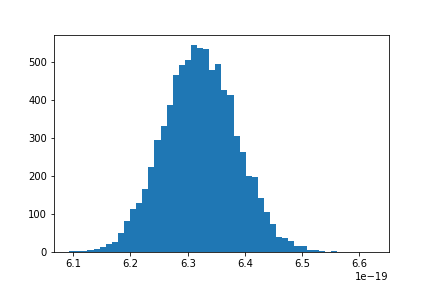

In [602]:
plt.figure()
plt.hist(powAvg, bins = 50);